In [534]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [535]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [536]:
import scipy
from scipy.interpolate import griddata

import matplotlib.ticker as ticker
import numpy as np

#Shell environment
import os
import sys
import subprocess		# to send python variables to shell.

# Permutations
import itertools


In [537]:
# Color plots
# Plot function    # Best till 170515
def plot_color(x, y, z, nx, ny, ax, c_scheme):
    
    # Axis units
    cx = 1
    cy = 1  # eV to meV 
    cz = 1  # Color renormalizaiton
    #nx = 512 # nk arpes
    #ny = 601  # nw arpes

    X = linspace( np.min(x),np.max(x),nx )
    Y = linspace( np.min(y),np.max(y),ny )
    Z = z.reshape((nx, ny))      #nk*nw = len(A)

    #Here we set imshow image x,y pixel range
    x1 = 0
    x2 = -1
    y1 = 0
    y2 = -1

    im = ax.imshow(Z[x1:x2, y1:y2].T, extent=(X[x1], X[x2], Y[y1], Y[y2]), origin='lower',interpolation='bicubic', cmap= c_scheme)
    
    # Here we set axis range
    ax.set_xlim(np.min( x )*cx, np.max( x )*cx )
    ax.set_ylim(np.min( y )*cy, np.max( y )*cy)
    
    # Hide X-Y ticks
    #ax.tick_params(axis='both', which='major', labelsize=18)
#     ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    
    # Set aspec ratio to remove h-,w-space.
    ax.set_aspect("auto")
    
    #Horizontal and vertical lines
    ax.plot((-pi, pi), (0.0, 0.0), 'k-', color='k',linewidth=0.6, ls='-',)
    ax.plot((-pi, pi), (0.0, 0.0), 'k-', color='k',linewidth=0.6, ls='-',)
    
    #ph window
    #ax.plot((-pi, pi), (0.2, 0.2), 'k-', color='k',linewidth=0.6, ls='--')
    ax.plot((-pi, pi), (-0.2, -0.2), 'k-', color='k',linewidth=0.6, ls='--')
   
    #ax.set_xlabel(r'$\mathrm{k_x = k_y}\ $', fontsize=18)
    #ax.set_ylabel(r'$\omega \,\mathrm{[meV]}$',fontsize=18)
    #fig.text(0.05, 0.51, r'$\omega\, \mathrm{[eV]}$',fontsize=24, va='center', rotation='vertical')
    return im



In [538]:
## Functions

#### Number of combinations
def choose(n, k):
#     https://stackoverflow.com/questions/3025162/statistics-combinations-in-python/3027128
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

#### Get the sign for the movement of a single fermionic operator  Uk...UjUi...U1U0|0> .
def getFermionSign(_iOpetrator, _iOfBasisOnlyOnes):
    _list_below = np.where( np.array(_iOfBasisOnlyOnes)> _iOpetrator )[0]
    if len(_list_below) >0:
        _num_loop = _list_below[-1] + 1 # This condition will pick the element where we need to move the operator at.
    else:
        _num_loop = 0
    _fermionSign = (-1)**_num_loop
#     print("n", _iTemp, _num_loop, _fermionSign)
    return _fermionSign,  np.insert(_iOfBasisOnlyOnes,_num_loop,_iOpetrator)


#### Basis vectors generation and indexing
def getBasis( _ns, _neU, _neD):
    '''
    * for NS sites, [0,NS-1] exponents are possible for base 2.
    * Out of those exponents, we pick NEU/D exponents to create a basis.
    * Binary representation will give us a readable basis.
    '''
    _site_exponents = np.array( [_ins for _ins in range(_ns)])
    _site_fillingU = list(itertools.combinations(_site_exponents,_neU))
    _site_fillingD = list(itertools.combinations(_site_exponents,_neD))
    
    _basisH=[]
    for _ifillU in range( len(_site_fillingU) ):
        for _ifillD in range( len(_site_fillingD) ):
            # Spin up eletron configuration decimal value.
            _id_basisU = 0
            for _ineU in range(_neU):
                _id_basisU += 2**_site_fillingU[_ifillU][_ineU]
            # Spin down eletron configuration decimal value. 
            _id_basisD = 0
            for _ineD in range(_neD):
                _id_basisD += 2**_site_fillingD[_ifillD][_ineD]    
            
            # Fill the basis
            _basisH.append([_id_basisU, _id_basisD])
    _basisH = np.array( _basisH )
    return _basisH

#### Number conversion
# Get binary
def getBinary(_n):
    return [int(x) for x in bin(_n)[2:]]

def getDecimal(_n): 
    _out = 0
    for _in, _value in enumerate(_n):
        _out += _value*2**(len(_n)-1-_in)
    return _out


In [ ]:
Conductivng phase: ns=8, nu=4,nd=4, u=0.0, t=0.1
Mott, same as above with u = 2.

In [552]:
######################## SIngle one

from scipy.sparse import identity
from scipy.sparse.linalg import eigs
from scipy.sparse import lil_matrix

#### Calculate filling
def calc_Hmu(_iBasis, _basis):
#     print(_basis)
    _sumTemp = 0.0
    for _iS in range(NS):
        if _basis[0][_iS] == 1:
            _sumTemp += mu
        if _basis[1][_iS] == 1 :
            _sumTemp += mu
    if np.fabs(_sumTemp) >0.0:
        if np.fabs( H[_iBasis,_iBasis]) < 0.0000000001:
            H[_iBasis,_iBasis] = -_sumTemp
        else:
            H[_iBasis,_iBasis] += -_sumTemp


#### H_intraction act on a basis
def calc_HU(_iBasis, _basis):
#     print(_basis)
    _sumTemp = 0.0
    for _iS in range(NS):
        if _basis[0][_iS] == 1 and _basis[1][_iS] ==1 :
            _sumTemp += u
    if _sumTemp >0.0:
        if np.fabs( H[_iBasis,_iBasis]) < 0.0000000001:
            H[_iBasis,_iBasis] = _sumTemp
        else:
            H[_iBasis,_iBasis] += _sumTemp
#             print(_iS)
#     print("Done with the interaction part")

def calc_HK(_iBasis, _basis):
    _posOnlyOnesU = []
    _posOnlyOnesD = []
    ### Find the operator sequence that create the input basis. 
    for _iS in range(NS): 
        _iSS = NS-1 -_iS # Decrement
        if _basis[0][_iSS] == 1:
            _posOnlyOnesU.insert(0,_iS)
        if _basis[1][_iSS] == 1:
            _posOnlyOnesD.insert(0,_iS)
    _posOnlyOnes = [_posOnlyOnesU, _posOnlyOnesD]
      
    #### Act HK and find the fermionic sign  
    
    ### Forward shift: c*(i+1)c(i)
    _mapped_basis = np.copy(_basis)
    for _iS in range(NS): 
        _iSS = NS-1 -_iS # Decrement
        ## Non-zero kinetic term index
        for _iSpin in range(2): # Loop over spin up and down basis part
            if _basis[_iSpin][_iSS] == 1 and _basis[_iSpin][ (_iSS-1)%NS ] ==0 : 
                # Find the mapped basis index
                _mapped_basis[_iSpin][(_iSS-1)%NS] = 1
                _mapped_basis[_iSpin][_iSS] = 0
                _target_basis = [getDecimal(_mapped_basis[0]), getDecimal(_mapped_basis[1])]
                # Search the index of the target basis
                _iTargetUpSpin = np.where( _target_basis[0] == basisH[:,0])
                _iTarget_basis = _iTargetUpSpin[0][ np.where( basisH[_iTargetUpSpin][:,1] == _target_basis[1] )[0] ] 
                # Get the sign
                _fermionSign1, _newSequence1 = getFermionSign(_iS, _posOnlyOnes[_iSpin] )
                _fermionSign2, _newSequence2 = getFermionSign((_iS+1)%NS, _newSequence1 )
                _fermionSign = _fermionSign1*_fermionSign2
                
                H[_iBasis,_iTarget_basis] = - _fermionSign * t
                _mapped_basis = np.copy(_basis)
         
        ### Backward shift: c*(i)c(i+1)
        for _iSpin in range(2): # Loop over spin up and down basis part
            if _basis[_iSpin][_iSS] == 0 and _basis[_iSpin][ (_iSS-1)%NS ] ==1 : 
                # Find the mapped basis index
                _mapped_basis[_iSpin][(_iSS-1)%NS] = 0
                _mapped_basis[_iSpin][_iSS] = 1
                _target_basis = [getDecimal(_mapped_basis[0]), getDecimal(_mapped_basis[1])]
                # Search the index of the target basis
                _iTargetUpSpin = np.where( _target_basis[0] == basisH[:,0])
                _iTarget_basis = _iTargetUpSpin[0][ np.where( basisH[_iTargetUpSpin][:,1] == _target_basis[1] )[0] ]
                # Get the sign
                _fermionSign1, _newSequence1 = getFermionSign((_iS+1)%NS, _posOnlyOnes[_iSpin] )
                _fermionSign2, _newSequence2 = getFermionSign(_iS, _newSequence1 )
                _fermionSign = _fermionSign1*_fermionSign2
                
                H[_iBasis,_iTarget_basis] = - _fermionSign * t
                _mapped_basis = np.copy(_basis)

#### Parameters
NS = 6 # Number of sites
NSpinU = 3 # Number of spin up
NSpinD = 3 # Number of spin down
u = 0.2
t = 0.25
mu = 0.0
# mu = u/2
####

#### H definition
dimH = choose(NS,NSpinU) * choose(NS,NSpinD)
H = lil_matrix((dimH, dimH))
### convert to csc
# print("Size in bytes: H_lil:",sys.getsizeof(H), "csr:", sys.getsizeof(H.tocsr()), " Full:", sys.getsizeof(H.toarray()) )
# H = H.tocsr()  # I do not think we need to convert to csr to get eigen values.
print("[NS, NU, ND, dim]", [NS, NSpinU, NSpinD, dimH])
####

### Create basis
basisH = getBasis(NS,NSpinU, NSpinD)
####

#### Fill H elements
for iBasis in range(len(basisH)):
    ### Extarct spin resolved basis and pad zeros at the begining.
    basisU = getBinary(basisH[iBasis][0])
    basisU = np.pad(basisU, ( NS - len(basisU),0), 'constant', constant_values=(0, 0))

    basisD = getBinary(basisH[iBasis][1])
    basisD = np.pad(basisD, ( NS - len(basisD),0), 'constant', constant_values=(0, 0))
    ### Combine
    basisComb = np.array( [basisU, basisD])
    ### Calculate H
    calc_HU( iBasis, basisComb )
    calc_HK( iBasis, basisComb )
    calc_Hmu(iBasis, basisComb )
# print(H)
# print(H.toarray())

#### Eigen values using sparse eigs routine
# eig_val, eig_vec = eigs(H, 10, which='SR')
# print("Eig values Sparse:", np.sort(real(eig_val)))
eig_val, eig_vec = eig(H.toarray())
# print("Eig values Full:", np.sort(eig_val))

[NS, NU, ND, dim] [6, 3, 3, 400]


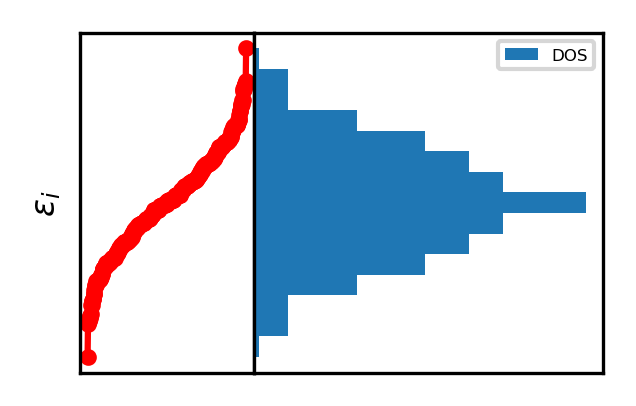

In [553]:
# Plots
import matplotlib.gridspec as gridspec
### Plot
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
marksize = 3
fontl = 8

gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0:1, 0:1])
ax1 = plt.subplot(gs[0:1, 1:3])

# xx = [ i for i in range(dimH)]
ax0.plot( np.sort(real(eig_val[:])), '-o', color='r', markersize = marksize, label='P(x)' )
count, bins, ignored = ax1.hist(real(eig_val), 15, density=True, orientation='horizontal', label='DOS')

# ax.set_ylim(0,10)
# ax.set_ylabel('X', fontsize = 1.2*fontl)
ax0.set_ylabel(r'$\epsilon_i$', fontsize = 1.0*fontl)
ax1.legend( loc='upper right', frameon = 'True', fontsize = 0.5*fontl)
ax0.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
# ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 
ax0.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 
ax1.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')

plt.show()

(1, 400)
[0.41494187+0.j 0.47247912+0.j 0.51953813+0.j 0.65812952+0.j
 0.55333424+0.j 0.3572056 +0.j] (2.9756284750099073+0j)


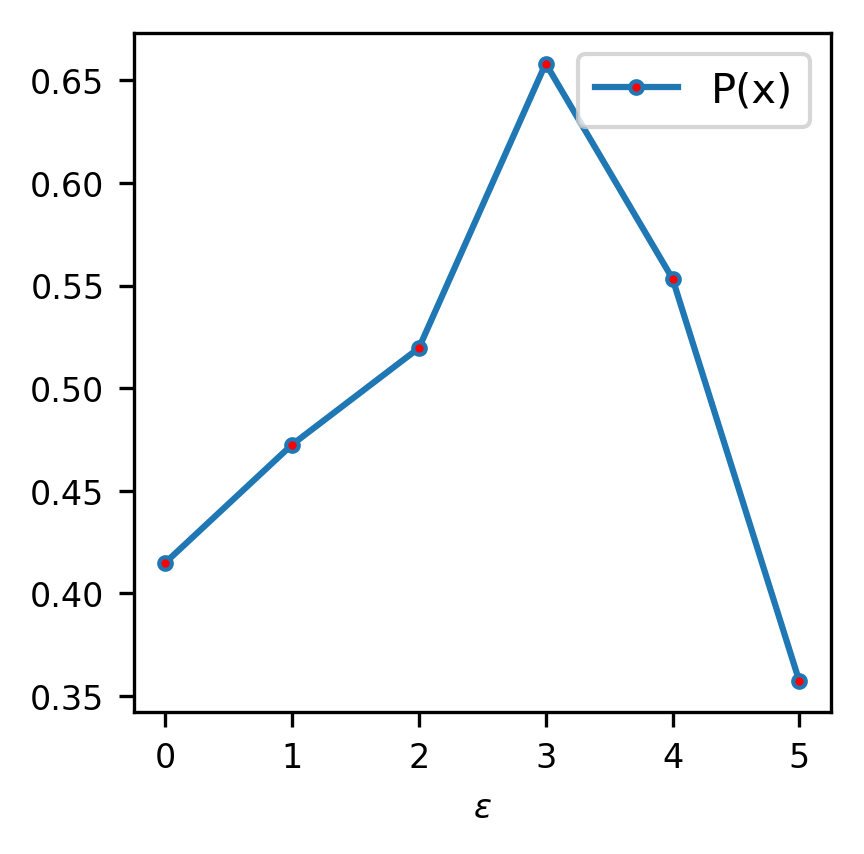

In [554]:
########## Eigen state analysis

#### GS
id_gs = np.where( eig_val == np.min(eig_val) )[0]
vec_gs = eig_vec[id_gs]
print(np.shape(vec_gs))
beta = 0.0

#### Calculate spin operator expectation value.
# spinOrder = np.array( [0.0+0.0*1j for _iBasis in range(len(basisH))])
# for iBasis in range(len(basisH)):
#     ### Extarct spin resolved basis and pad zeros at the begining.
#     basisU = getBinary(basisH[iBasis][0])
#     basisU = np.pad(basisU, ( NS - len(basisU),0), 'constant', constant_values=(0, 0))

#     basisD = getBinary(basisH[iBasis][1])
#     basisD = np.pad(basisD, ( NS - len(basisD),0), 'constant', constant_values=(0, 0))
#     ### Combine
#     basisComb = np.array( [basisU, basisD])
    
#     for _iEigVec  in range(len(eig_vec)):
#         ### Calculate spin order
#         _sumTempU = 0.0
#         _sumTempD = 0.0
#         for _iS in range(NS):
#             if basisComb[0][_iS] == 1:
#                 _sumTempU += 1
#             if basisComb[1][_iS] == 1 :
#                 _sumTempD += 1
#         vertex = np.dot( eig_vec[_iEigVec][iBasis], eig_vec[_iEigVec][iBasis]) 
# #         spinOrder[_iEigVec] += (_sumTempU-_sumTempD) *vertex * np.exp( - beta * eig_val[_iEigVec] ) 
#         spinOrder[_iEigVec] += np.exp(-1j*(_sumTempU-_sumTempD) ) *vertex * np.exp( - beta * eig_val[_iEigVec] ) 

spinOrder = np.array( [0.0+0.0*1j for _iBasis in range(NS)])

### Calculate spin order
# _sumTemp = 0.0
for _iSS in range(NS):
    for _iS in range(NS):
        for iBasis in range(len(basisH)):
            ### Extarct spin resolved basis and pad zeros at the begining.
            basisU = getBinary(basisH[iBasis][0])
            basisU = np.pad(basisU, ( NS - len(basisU),0), 'constant', constant_values=(0, 0))

            basisD = getBinary(basisH[iBasis][1])
            basisD = np.pad(basisD, ( NS - len(basisD),0), 'constant', constant_values=(0, 0))
            ### Combine
            basisComb = np.array( [basisU, basisD])
            
#             print( "Hello", vec_gs[0])
            _sumTempISS = basisComb[0][_iSS] - basisComb[1][_iSS]
            _sumTempIS = (-1)**_iS * (basisComb[0][(_iS+_iSS)%NS] - basisComb[1][(_iS+_iSS)%NS])
        
            vertex = np.dot( vec_gs[0][iBasis], vec_gs[0][iBasis]) 
            spinOrder[_iSS] += _sumTempISS*_sumTempIS *vertex * np.exp( - beta * eig_val[id_gs] ) 
#             spinOrder[_iEigVec] += np.exp(-1j*(_sumTempU-_sumTempD) ) *vertex * np.exp( - beta * eig_val[_iEigVec] ) 
    
# p
# print(spinOrder)
print(spinOrder, np.sum(spinOrder))

# Plots
### Plot
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
marksize = 3
fontl = 8

# DOS

ax.plot(np.real(spinOrder), '-o', markerfacecolor='r', markersize = marksize, label='P(x)' )

# ax.set_ylim(0,10)
# ax.set_ylabel('X', fontsize = 1.2*fontl)
ax.set_xlabel(r'$\epsilon$', fontsize = 1.0*fontl)
ax.legend( loc='upper right', frameon = 'True')
ax.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
# ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 
# ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')

plt.show()

(1, 400)


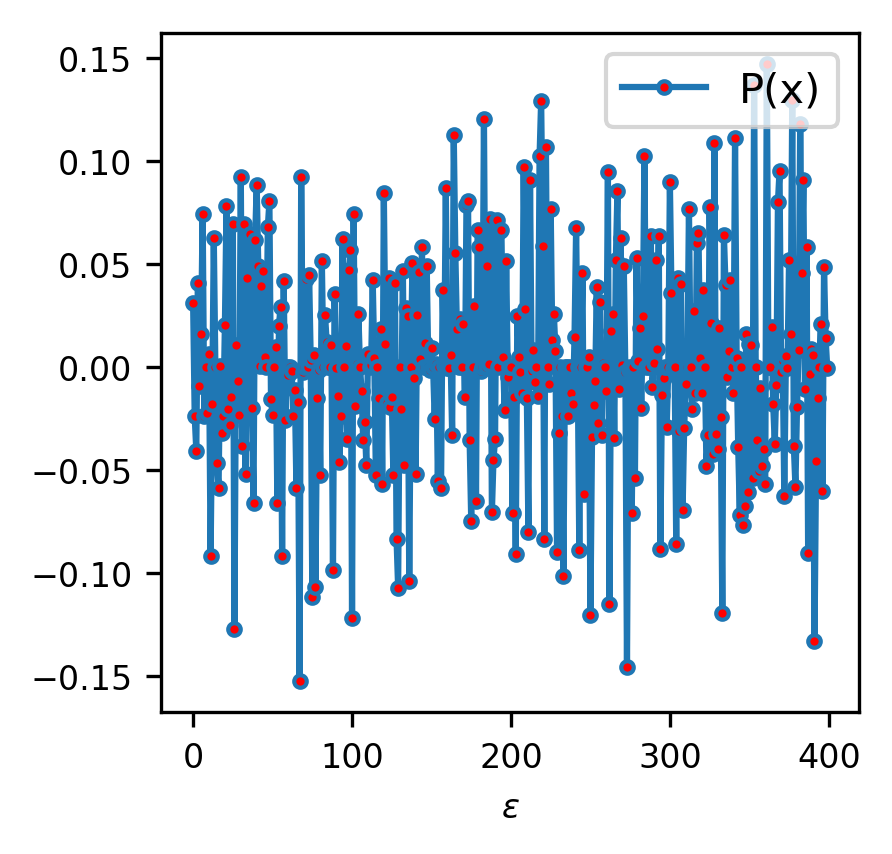

In [528]:
### Spin analysis
eig_vec[1]
id_gs = np.where( eig_val == np.min(eig_val) )[0]
vec_gs = eig_vec[id_gs]
print(np.shape(vec_gs))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
marksize = 3
fontl = 8

# DOS

ax.plot(np.real(vec_gs[0]), '-o', markerfacecolor='r', markersize = marksize, label='P(x)' )

# ax.set_ylim(0,10)
# ax.set_ylabel('X', fontsize = 1.2*fontl)
ax.set_xlabel(r'$\epsilon$', fontsize = 1.0*fontl)
ax.legend( loc='upper right', frameon = 'True')
ax.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
# ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 
# ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')

plt.show()

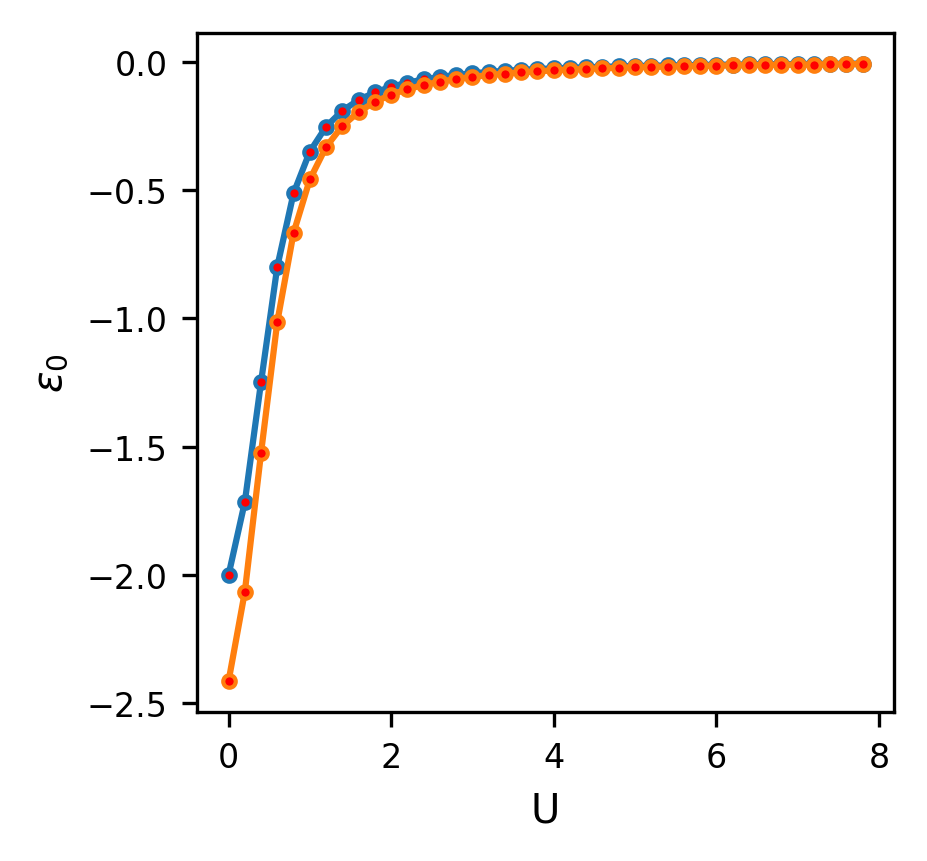

In [570]:

# Plots
### Plot
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
marksize = 3
fontl = 8

# GS energy
ax.plot(e0N6[:,0],e0N6[:,3], '-o', markerfacecolor='r', markersize = marksize, label='NS=6' )
ax.plot(e0N8[:,0],e0N8[:,3], '-o', markerfacecolor='r', markersize = marksize, label='NS=6' )

# ax.set_ylim(0,10)
ax.set_xlabel('U', fontsize = 1.2*fontl)
ax.set_ylabel(r'$\epsilon_0$', fontsize = 1.2*fontl)
# ax.legend( loc='upper right', frameon = 'True')
ax.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
#ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')

plt.show()

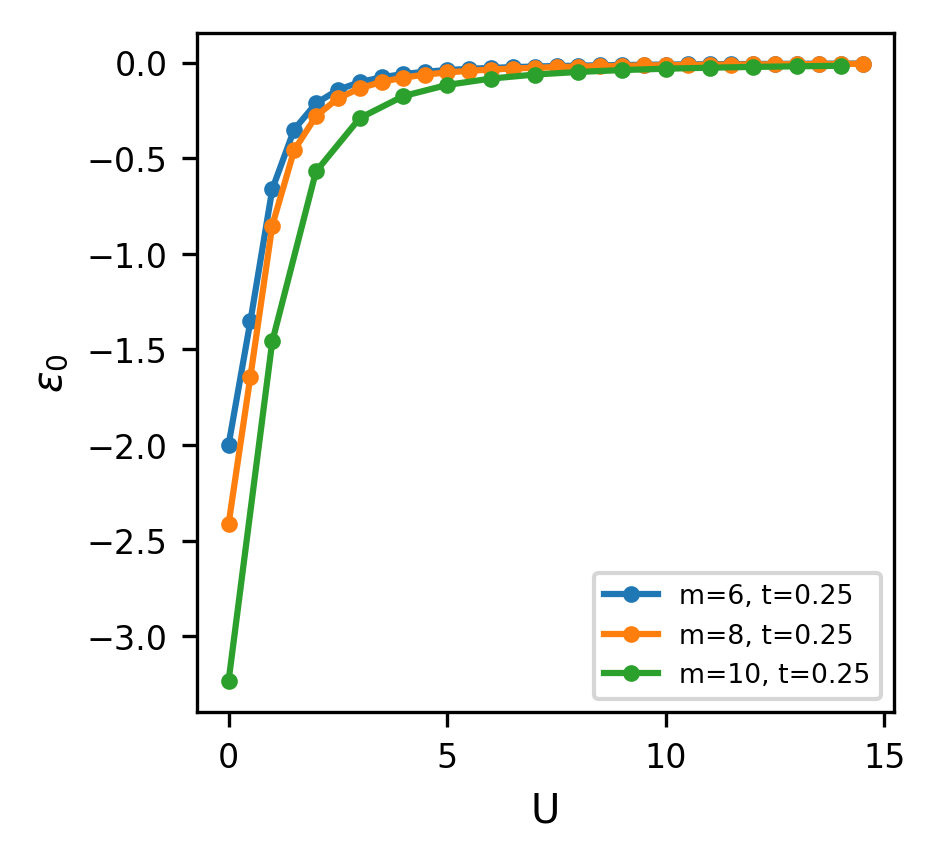

In [607]:
# Plot data using stored files.
# GS as U
d1 = np.genfromtxt("extra_runs/ns6/out.dat")
d2 = np.genfromtxt("extra_runs/ns8/out.dat")
d3 = np.genfromtxt("extra_runs/ns10/out.dat")

# Plots
### Plot
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
marksize = 3
fontl = 8

# GS energy
ax.plot(d1[:,0],d1[:,3], '-o', markersize = marksize, label='m=6, t=0.25' )
ax.plot(d2[:,0],d2[:,3], '-o', markersize = marksize, label='m=8, t=0.25' )
ax.plot(d3[:,0],d3[:,3], '-o', markersize = marksize, label='m=10, t=0.25' )

# ax.plot(e0N8[:,0],e0N8[:,3], '-o', markerfacecolor='r', markersize = marksize, label='NS=6' )

# ax.set_ylim(0,10)
ax.set_xlabel('U', fontsize = 1.2*fontl)
ax.set_ylabel(r'$\epsilon_0$', fontsize = 1.2*fontl)
ax.legend( loc='lower right', frameon = 'True', fontsize = 0.8*fontl)
ax.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
#ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')
plt.show()



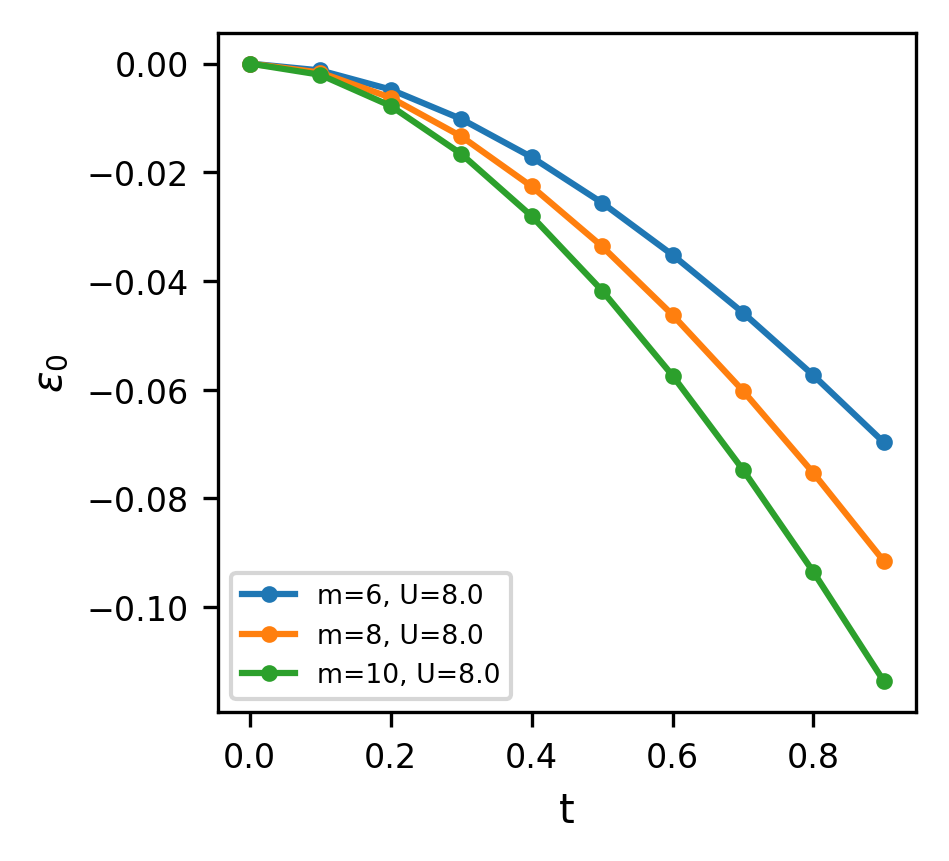

In [608]:
# Plot data using stored files.
# GS as t
# d2 = np.genfromtxt("extra_runs/ns8/out.dat")
# d3 = np.genfromtxt("extra_runs/ns10/out.dat")

# Plots
### Plot
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=300)
marksize = 3
fontl = 8

# GS energy
d1 = np.genfromtxt("extra_runs/ns6/HK/u8_out.dat")
ax.plot(d1[:,1],d1[:,3], '-o', markersize = marksize, label='m=6, U=8.0' )

d1 = np.genfromtxt("extra_runs/ns8/HK/u8_out.dat")
ax.plot(d1[:,1],d1[:,3], '-o', markersize = marksize, label='m=8, U=8.0' )

d1 = np.genfromtxt("extra_runs/ns10/HK/u8_out.dat")
ax.plot(d1[:,1],d1[:,3], '-o', markersize = marksize, label='m=10, U=8.0' )

# d1 = np.genfromtxt("extra_runs/ns6/HK/u0_out.dat")
# ax.plot(d1[:,1],d1[:,3], '--x', markersize = marksize, label='m=6, U=0.0' )

# d1 = np.genfromtxt("extra_runs/ns8/HK/u0_out.dat")
# ax.plot(d1[:,1],d1[:,3], '--x', markersize = marksize, label='m=8, U=0.0' )

# ax.plot(e0N8[:,0],e0N8[:,3], '-o', markerfacecolor='r', markersize = marksize, label='NS=6' )

# ax.set_ylim(0,10)
ax.set_xlabel('t', fontsize = 1.2*fontl)
ax.set_ylabel(r'$\epsilon_0$', fontsize = 1.2*fontl)
ax.legend( loc='lower left', frameon = 'True', fontsize = 0.8*fontl)
ax.tick_params(axis='both', which='major', labelsize=1.0*fontl) 
#ax.tick_params(axis='y', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off', labelsize=0.4*fontl) 

fig.savefig('test.eps', bbox_inches='tight')
fig.savefig('test.pdf', bbox_inches='tight')
fig.savefig('test.jpg', bbox_inches='tight')
plt.show()

